In [1]:
import sys

robot_packages = "/opt/openrobots/lib/python3.7/site-packages/"
if robot_packages not in sys.path:
    sys.path.insert(0, "/opt/openrobots/lib/python3.7/site-packages/")
else:
    print('robot_packages already in sys.path')

iter     cost         stop         grad         xreg         ureg       step    ||ffeas||
   0  5.82097e-03  3.53677e-04  -2.26102e-02  1.00000e-09  1.00000e-09  1.0000  3.14000e+00
   1  2.81683e-03  6.70894e-07  5.51890e-03  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   2  2.53602e-03  6.87963e-08  4.49879e-04  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   3  2.48638e-03  1.03872e-08  7.26617e-05  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   4  2.47551e-03  2.02495e-09  1.50308e-05  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   5  2.47276e-03  4.90019e-10  3.67278e-06  1.00000e-09  1.00000e-09  1.0000  0.00000e+00


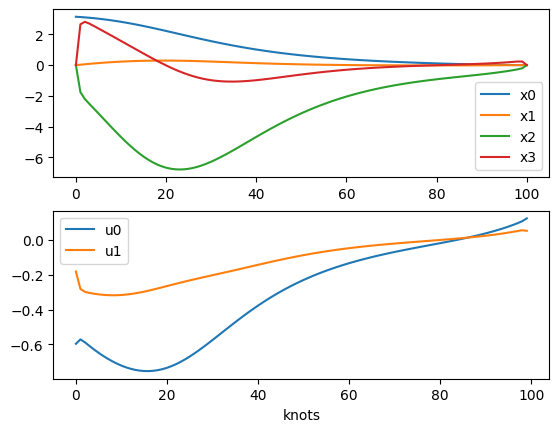

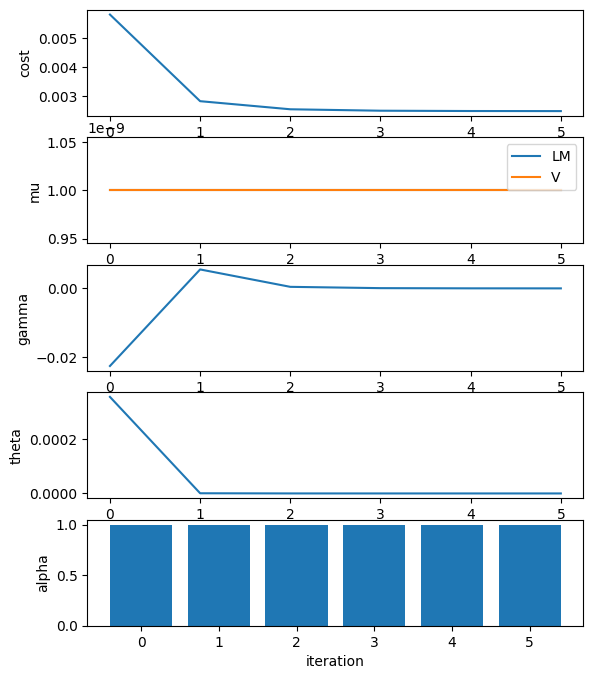

In [18]:
import os
import sys
import crocoddyl
import numpy as np
import example_robot_data
import matplotlib.pyplot as plt 
from crocoddyl.utils.pendulum import CostModelDoublePendulum, ActuationModelDoublePendulum


#Class for defining planner for double pendulum with Crocoddyl
class DoublePendulumPlanner:

    # Initialize visualization and plotting options
    # Load the double pendulum model
    # Define the state and actuation models
    # Define the running and terminal cost models
    def __init__(self, with_display, with_plot):
        self.with_display = with_display
        self.with_plot = with_plot

        self.pendulum = example_robot_data.load('double_pendulum')
        self.model = self.pendulum.model

        self.state = crocoddyl.StateMultibody(self.model)
        self.actuation = crocoddyl.ActuationModelFull(self.state)

        self.running_cost_model = crocoddyl.CostModelSum(self.state, self.actuation.nu)
        self.terminal_cost_model = crocoddyl.CostModelSum(self.state, self.actuation.nu)

        self.create_cost_models()
        self.create_action_models()


    # Define the cost models for the state and control inputs
    # Define the double pendulum-specific cost model
    # Add cost models to the running and terminal cost models
    def create_cost_models(self):
        nu = self.actuation.nu #num control inputs
        x_residual = crocoddyl.ResidualModelState(self.state, self.state.zero(), nu) #residual: x-xref
        x_activation = crocoddyl.ActivationModelQuad(self.state.ndx) #quadratic state cost

        u_residual = crocoddyl.ResidualModelControl(self.state, nu) #u_desired - u_current (penalizes too much control deviation, keeps stable)
        x_reg_cost = crocoddyl.CostModelResidual(self.state, x_activation, x_residual)
        u_reg_cost = crocoddyl.CostModelResidual(self.state, u_residual)

        #cost for deviation of end eff. position of pendulum from goal
        #goal position implicitly set here
        x_pend_cost = CostModelDoublePendulum(self.state, crocoddyl.ActivationModelWeightedQuad(np.array([1.] * 4 + [0.1] * 2)), nu)

        dt = 1e-2
        self.running_cost_model.addCost("uReg", u_reg_cost, 1e-4 / dt)
        self.running_cost_model.addCost("xGoal", x_pend_cost, 1e-5 / dt)
        self.terminal_cost_model.addCost("xGoal", x_pend_cost, 100.)

    # Create the running and terminal action models using the Euler integration scheme
    def create_action_models(self):
        dt = 1e-2
        self.running_model = crocoddyl.IntegratedActionModelEuler(
            crocoddyl.DifferentialActionModelFreeFwdDynamics(self.state, self.actuation, self.running_cost_model), dt)
        self.terminal_model = crocoddyl.IntegratedActionModelEuler(
            crocoddyl.DifferentialActionModelFreeFwdDynamics(self.state, self.actuation, self.terminal_cost_model), dt)
    
    # 1) Set up the shooting problem and solver
    # 2) Configure the solver's callback functions for display and plotting
    # 3) Solve the optimization problem
    # 4) Plot the solution and convergence information if required
    # 5) Display the optimized trajectory if required

    def plan(self, T=100, x0=np.array([3.14, 0., 0., 0.])):
        problem = crocoddyl.ShootingProblem(x0, [self.running_model] * T, self.terminal_model)
        solver = crocoddyl.SolverFDDP(problem)

        camera_tf = [1.4, 0., 0.2, 0.5, 0.5, 0.5, 0.5]
        if self.with_display and self.with_plot:
            display = crocoddyl.GepettoDisplay(self.pendulum, 4, 4, camera_tf, False)
            solver.setCallbacks(
                [crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
        elif self.with_display:
            display = crocoddyl.GepettoDisplay(self.pendulum, 4, 4, camera_tf, False)
            solver.setCallbacks([crocoddyl.CallbackVerbose(), crocoddyl.CallbackDisplay(display)])
        elif self.with_plot:
            solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
        else:
            solver.setCallbacks([crocoddyl.CallbackVerbose()])

        solver.solve()

        if self.with_plot:
            log = solver.getCallbacks()[0]
            crocoddyl.plotOCSolution(log.xs, log.us, figIndex=1, show=False)
            crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps, figIndex=2)
            plt.show()  

        if self.with_display:
            display = crocoddyl.GepettoDisplay(self.pendulum, floor=False)
            display.displayFromSolver(solver)

# Set display and plotting options
# Create a DoublePendulumPlanner instance and run the planner

def main():
    with_display = False #requires Gepetto viewer
    with_plot = True
    planner = DoublePendulumPlanner(with_display=False, with_plot=with_plot)
    planner.plan()


# Figure 1: State Trajectories
#   - Subplot 1: The angle of the first link (x0) and the angle of the second link (x1) vs knots (time steps)
#   - Subplot 2: The angular velocity of the first link (x2) and the angular velocity of the second link (x3) vs knots (time steps)

# Figure 2: Convergence
#   - Subplot 1: Cost evolution over the iterations
#   - Subplot 2: Mu: actual reduction, or decrease in cost after taking a step
#   - Subplot 3: Gamma: algorithm stops when cost improvement over 2 iterations < gamma
#   - Subplot 4: Theta: norm of gradient of total cost function w.r.t control trajectory (how far current soln is from optimal one)
#   - Subplot 5: Alpha: scaling factor of the search direction for convergence

if __name__ == '__main__':
    main()



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3f508312-b056-4c11-9225-835431301ef2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>